In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf
from scipy.signal import lfilter

[OLSBLMS] Completed in 19.502 ms | iters=1250


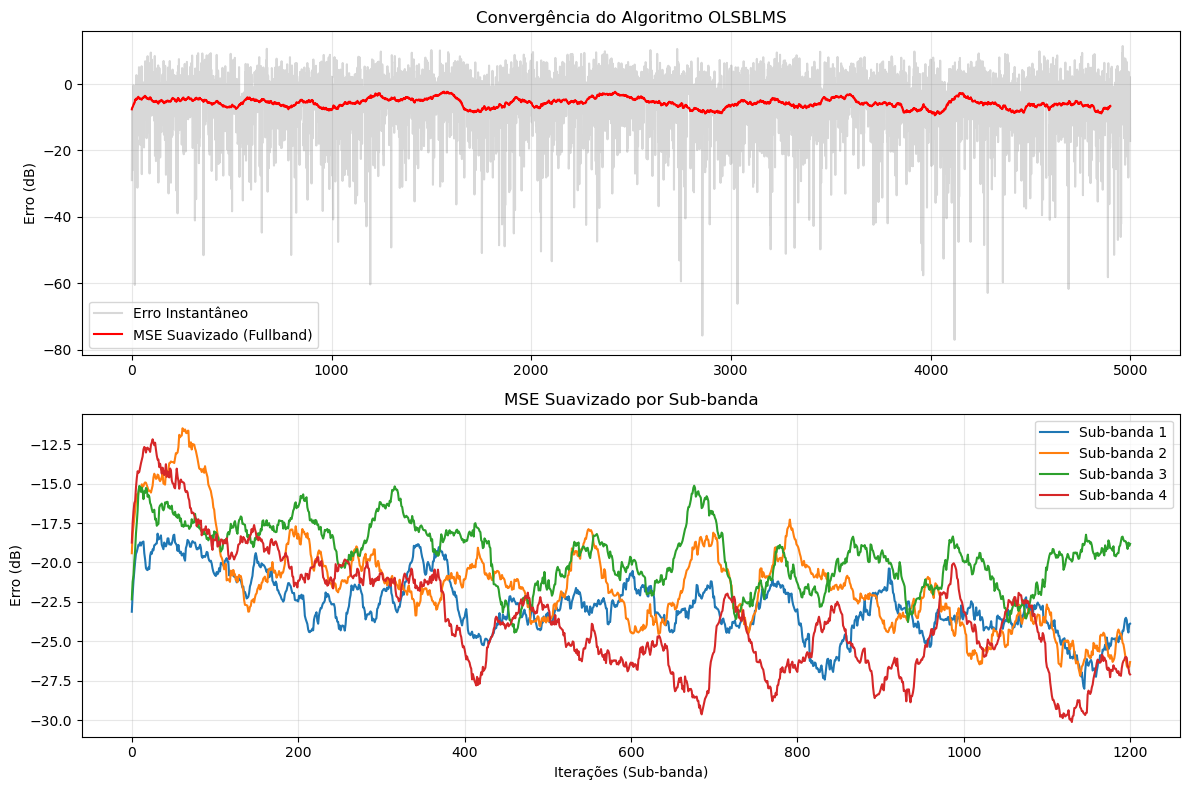

MSE Final (Overall): -13.34 dB


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1. Carregar os filtros do arquivo enviado (cosmod_4_64.mat)
# Este arquivo contém as matrizes 'hk' (análise) e 'fk' (síntese)
data = loadmat('cosmod_4_64.mat')
hk = data['hk']
fk = data['fk']
M  = data['M'].item() # Número de sub-bandas (4)

# 2. Parâmetros da Simulação
n_samples = 5000
Nw = 15          # Ordem do filtro em cada sub-banda
step_size = 0.05      # Passo de convergência (u)

# Criar um sistema desconhecido (Planta FIR)
w_unknown = np.random.randn(64) 
w_unknown /= np.linalg.norm(w_unknown)

# Gerar sinais
x = np.random.randn(n_samples) # Entrada: Ruído Branco
d_clean = np.convolve(x, w_unknown, mode='full')[:n_samples]
noise = 0.01 * np.random.randn(n_samples)
d = d_clean + noise # Sinal desejado com ruído

# 3. Instanciar e Rodar o OLSBLMS
# (Certifique-se de que a classe OLSBLMS definida por você esteja na célula acima)
flt = pdf.OLSBLMS(
    n_subbands=M,
    analysis_filters=hk,
    synthesis_filters=fk,
    filter_order=Nw,
    step_size=step_size,
    gamma=0.008,
    a=0.01
)

results = flt.optimize(x, d, verbose=True)

# 4. Visualização dos Resultados
plt.figure(figsize=(12, 8))

# Subplot 1: Erro Fullband (Reconstruído)
plt.subplot(2, 1, 1)
mse_db = 10 * np.log10(results.errors**2 + 1e-10)
plt.plot(mse_db, color='gray', alpha=0.3, label='Erro Instantâneo')
plt.plot(np.convolve(mse_db, np.ones(100)/100, mode='valid'), color='red', label='MSE Suavizado (Fullband)')
plt.title("Convergência do Algoritmo OLSBLMS")
plt.ylabel("Erro (dB)")
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Erros Individuais por Sub-banda
plt.subplot(2, 1, 2)
for m in range(M):
    mse_sb = 10 * np.log10(results.extra['mse_subbands'][m] + 1e-10)
    plt.plot(np.convolve(mse_sb, np.ones(50)/50, mode='valid'), label=f'Sub-banda {m+1}')

plt.title("MSE Suavizado por Sub-banda")
plt.xlabel("Iterações (Sub-banda)")
plt.ylabel("Erro (dB)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final (Overall): {10*np.log10(results.extra['mse_overall'][-1]):.2f} dB")

# Teste 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import firwin
import pydaptivefiltering as pdf

In [5]:
# --- 1. CONFIGURAÇÃO DOS BANCOS DE FILTROS ---
# Para sub-bandas, precisamos de filtros de análise (hk) e síntese (fk)
M = 4          # Número de sub-bandas
L = 4          # Fator de decimação (tipicamente L = M)
taps = 32      # Comprimento dos filtros do banco

# Criando um banco de filtros simples via modulação (Coseno)
proto = firwin(taps, 1/M)
hk = np.zeros((M, taps))
fk = np.zeros((M, taps))
for m in range(M):
    # Modulação simplificada para teste
    mod = np.cos(np.pi * m * np.arange(taps) / M)
    hk[m, :] = proto * mod
    fk[m, :] = proto * mod * M # Compensação de ganho para síntese

# --- 2. GERANDO DADOS ---
np.random.seed(42)
n_samples = 4000
# Entrada: Ruído colorido (convergência lenta para LMS comum, rápida para Sub-bandas)
x = np.convolve(np.random.randn(n_samples), [1, 0.9, 0.8, 0.7], mode='same')

# Planta desconhecida (Filtro de banda cheia)
w_true = firwin(31, 0.3)
d = np.convolve(x, w_true, mode='same') + 0.01 * np.random.randn(n_samples)

# --- 3. EXECUÇÃO DO OLSBLMS ---
# filter_order aqui é a ordem DO FILTRO EM CADA SUB-BANDA
nw_subband = 8 

filt_olsb = pdf.OLSBLMS(
    n_subbands=M,
    analysis_filters=hk,
    synthesis_filters=fk,
    filter_order=nw_subband,
    decimation_factor=L,
    step_size=0.1,
    gamma=1e-2,
    a=0.05
)

result = filt_olsb.optimize(x, d, verbose=True)

[OLSBLMS] Completed in 16.003 ms | iters=1000


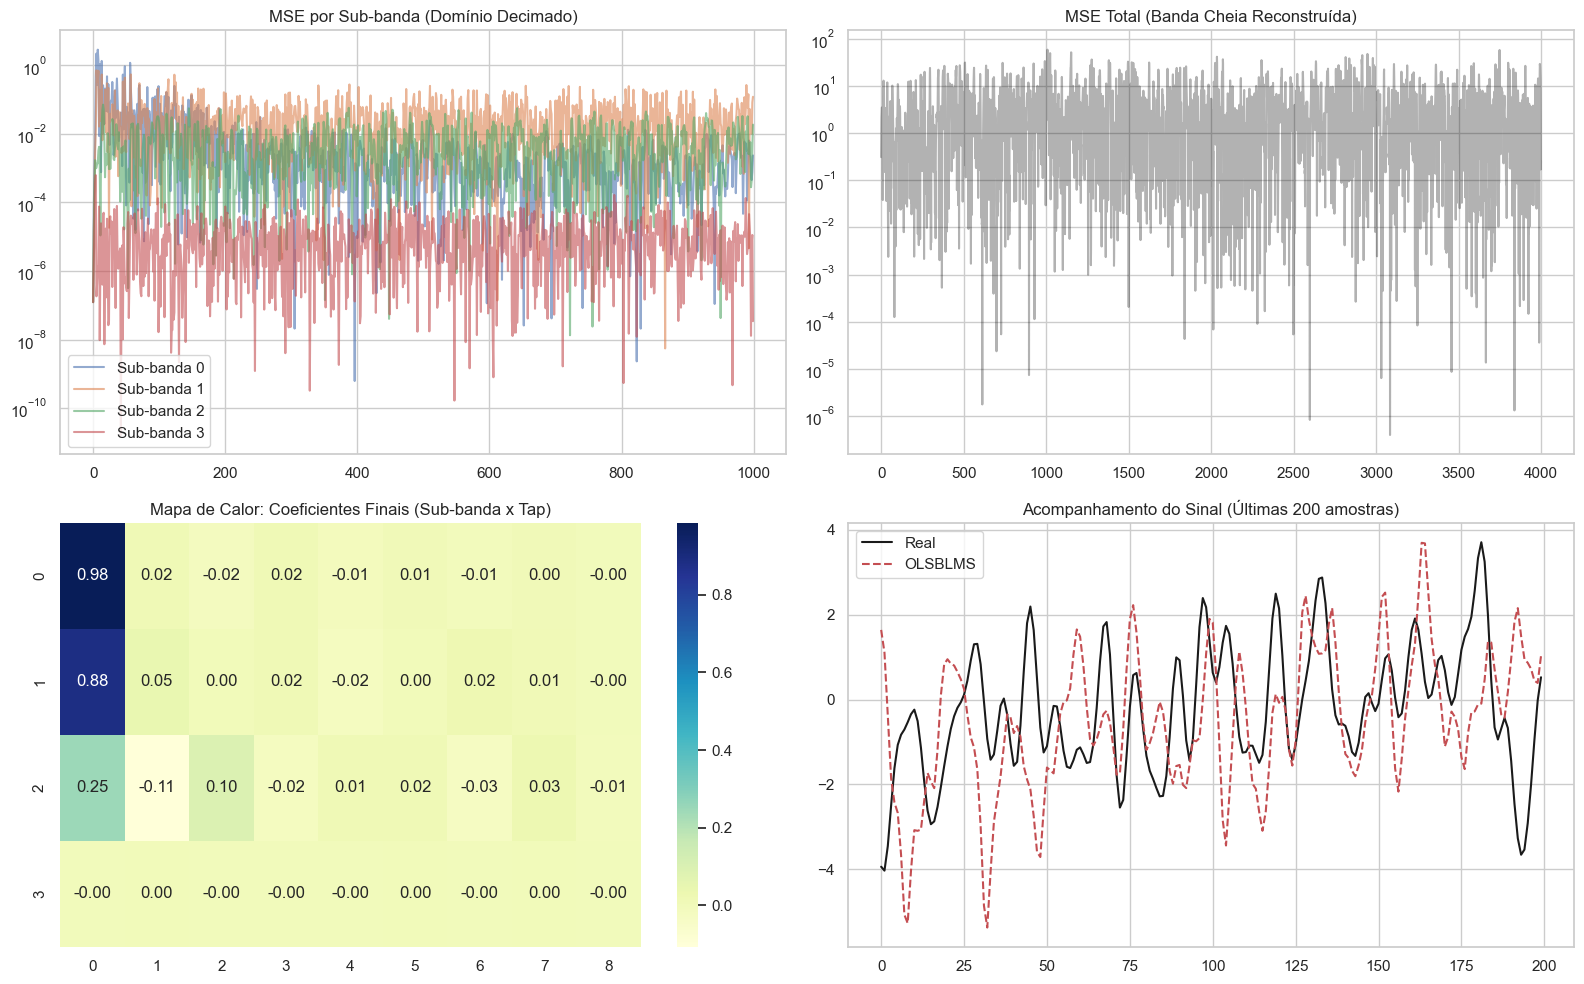

In [6]:
# --- 4. VISUALIZAÇÃO DOS RESULTADOS ---
def plot_olsb_results(result, M):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # A. Erro nas Sub-bandas
    ax1 = axes[0, 0]
    mse_sb = result.extra['mse_subbands']
    for m in range(M):
        ax1.semilogy(mse_sb[m, :], label=f'Sub-banda {m}', alpha=0.6)
    ax1.set_title("MSE por Sub-banda (Domínio Decimado)")
    ax1.legend()

    # B. Erro Global Reconstruído
    ax2 = axes[0, 1]
    ax2.semilogy(result.errors**2, color='black', alpha=0.3)
    ax2.set_title("MSE Total (Banda Cheia Reconstruída)")

    # C. Coeficientes (Matriz de Pesos)
    ax3 = axes[1, 0]
    w_final = result.extra['w_matrix_history'][-1]
    sns.heatmap(w_final, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax3)
    ax3.set_title("Mapa de Calor: Coeficientes Finais (Sub-banda x Tap)")

    # D. Comparação de Sinais (Zoom)
    ax4 = axes[1, 1]
    ax4.plot(d[-200:], 'k', label='Real')
    ax4.plot(result.outputs[-200:], 'r--', label='OLSBLMS')
    ax4.set_title("Acompanhamento do Sinal (Últimas 200 amostras)")
    ax4.legend()

    plt.tight_layout()
    plt.show()

plot_olsb_results(result, M)